# Smith-Wilson Yield Curve Model Implementation

This notebook demonstrates the implementation and usage of the Smith-Wilson yield curve model, which is commonly used by insurers and central banks for interest rate term structure modeling. The model is particularly useful for extrapolating yield curves beyond the last liquid point while ensuring convergence to a long term forward rate (LTFR).

## Key Features of the Smith-Wilson Model
1. Exact fit to input market rates
2. Ability to generate both zero rates and forward rates
3. Convergence to a predefined stable long term forward rate (LTFR)
4. Smooth modelling of both interpolated and extrapolated values

## Smith-Wilson fitting technique
In their 2000 paper *"Fitting Yield Curves with Long Term Constraints"*, Andrew Smith and Tim Wilson proposed to model the price of a bond using a smooth, positive, decreasing function which exponentially tends to 0 for large terms.
This price is made of a term representing the asymptotic contribution and a set of kernel function:
P(t) = exp(-LTFR.t) + weight_1.kernel_function_1(1,t) + ... weight_N.kernel_function_N(N,t)

For the kernel functions, they proposed the symetric Wilson's function: 
W(t,u) = 

The pricing function is obtained by transforming a set of discrete values (observed market prices) into a continuous function while exactly replicating the original discrete values. The shape of the curve after the last discrete input is defined by two external parameters describing the speed of the asymptotic convergence (alpha) toward the asymptotic contribution (LTFR).

## Let's start by importing the required libraries

In [2]:
from math import log, exp, sinh, cosh
import numpy as np
from typing import List, Tuple, Optional
import matplotlib.pyplot as plt

# Set plot style
plt.style.use('bmh')
%matplotlib inline

## Model Implementation

Below is the implementation of the Smith-Wilson model class. The class includes methods for calculating zero rates, forward rates, and visualizing the yield curves.

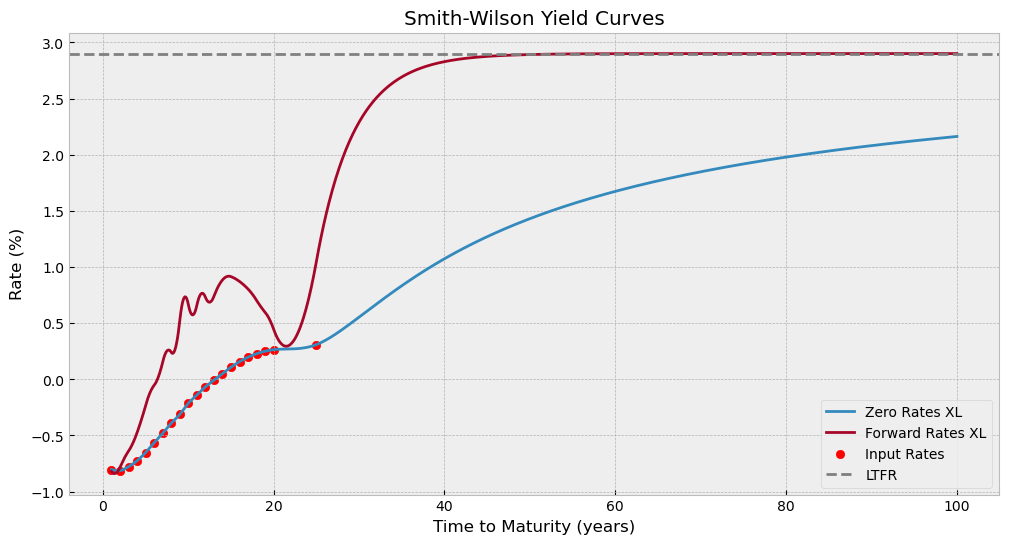

In [4]:
class SmithWilsonCurve:
    """
    Implementation of the Smith-Wilson yield curve model.
    
    The Smith-Wilson method is used to create a continuous yield curve from a set of observed 
    market prices or rates, particularly useful for extrapolating beyond the last observed term.
    """
    def __init__(self,
                 LTFR: float,
                 alpha: float,
                 rates: np.ndarray,
                 t: Optional[np.ndarray] = None):
        """
        Initialize the Smith-Wilson model.
        
        Args:
            LTFR: Long Term Forward Rate (as decimal, e.g., 0.029 for 2.9%)
            alpha: Convergence parameter
            rates: Array of observed zero rates (as decimal)
            t: Optional array of observed maturities in years
        """
        self.LTFR = LTFR
        self.alpha = alpha
        self.rates = np.array(rates)
        self.t = np.array(t) if t is not None else np.arange(1, 1+len(self.rates))
        self.Qb = self._calculate_Qb()
    
    def _H_function(self, u: float, v: float, alpha: Optional[float] = None) -> float:
        """ Calculate the heart of the Wilson function """
        if alpha is None: alpha = self.alpha
        return alpha * min(u,v) - np.exp(-alpha * max(u,v)) * sinh(alpha * min(u,v))

    def _calculate_Qb(self, alpha: Optional[float] = None) -> np.ndarray:
        """ """
        if alpha is None: alpha = self.alpha
        H_matrix = np.array([[self._H_function(u, v, alpha) for v in self.t] for u in self.t])
        P = np.zeros(len(self.t))
        for i, ri in enumerate(self.rates):
            tenor = self.t[i]
            P[i] = ((1 + LTFR)/(1+ri))**tenor - 1
        return np.linalg.solve(H_matrix, P)
    
    def _G_function(self, u: float, v: float, alpha: Optional[float] = None) -> float:
        """ Calculate the derivative of the heart of the Wilson function """
        if alpha is None: alpha = self.alpha
        if v <= u:
            result = alpha - alpha * exp(-alpha * u) * cosh(alpha * v)
        else:
            result = alpha * exp(-alpha * v) * sinh(alpha * u)
        
        return result
    
    def SmithWilson_Zero_Rate(self, t: float):
        """ Obtain the zero rate r from the Smith-Wilson model. Price is then exp( -r.t ) """
        if isinstance(t, (int, float)): t = np.array([t])

        # Calculate the H matrix needed for the HQb calculation
        H = np.array([[self._H_function(u, v) for v in self.t] for u in t])
        
        # Calculate the zero rate
        r = (1+self.LTFR) / ( (1 + H @ self.Qb) ** (1/t) ) - 1
        
        return r[0] if len(r) == 1 else r
    
    def SmithWilson_Forward_Rate(self, t: float):
        """ Obtain the forward rate f from the Smith-Wilson model. """
        if isinstance(t, (int, float)): t = np.array([t])

        # Calculate the H and G matrix needed for the HQb and GQb calculation
        H = np.array([[self._H_function(u, v) for v in self.t] for u in t])
        G = np.array([[self._G_function(u, v) for v in t] for u in self.t]).T
       
        f = (1+self.LTFR) / np.exp( G @ self.Qb / (1 + H @ self.Qb ) ) - 1
        
        return f[0] if len(f) == 1 else f

# Example usage
def plot_sw_curves(sw: SmithWilsonCurve, max_t: float = 100, num_points: int = 1000) -> None:
    """
    Plot the zero rates and forward rates curves.
    
    Args:
        max_t: Maximum time to plot (in years)
        num_points: Number of points to plot
    """
    t_plot = np.linspace(1, max_t, num_points)
    input_rates = sw.rates
    input_tenors = sw.t
    zero_rates = sw.SmithWilson_Zero_Rate(t_plot)
    forward_rates = sw.SmithWilson_Forward_Rate(t_plot)
    LTFR = sw.LTFR
    
    plt.figure(figsize=(12, 6))
    plt.plot(t_plot, zero_rates * 100, label='Zero Rates XL')
    plt.plot(t_plot, forward_rates * 100, label='Forward Rates XL')
    plt.scatter(input_tenors, input_rates * 100, color='red', label='Input Rates')
    plt.axhline(LTFR * 100, color='gray', linestyle='--', label='LTFR')
    
    plt.title('Smith-Wilson Yield Curves')
    plt.xlabel('Time to Maturity (years)')
    plt.ylabel('Rate (%)')
    plt.grid(True)
    plt.legend()
    plt.show()

if __name__ == "__main__":
    # Example data
    LTFR = 0.029  # 2.9%
    alpha = 0.21204174041748
    # Create model, with data from Y1 to Y20 and also Y25
    spot_rates = [-0.00803, -0.00814, -0.00778, -0.00725, -0.00652,
              -0.00565, -0.0048, -0.00391, -0.00313, -0.00214,
              -0.0014, -0.00067, -0.00008, 0.00051, 0.00108,
              0.00157, 0.00197, 0.00228, 0.0025, 0.00264,
              0.00309]
    t = np.array([1, 2, 3, 4, 5,
                  6, 7, 8, 9, 10,
                  11, 12, 13, 14, 15,
                  16, 17, 18, 19, 20,
                  25])
    
    sw = SmithWilsonCurve(LTFR=LTFR, alpha=alpha, rates=spot_rates, t=t )
    
    # Plot curves
    plot_sw_curves(sw)
    #sw.plot_curves()
